# 1. Import thư viện

In [1]:
import time
import pickle
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow import keras
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.layers import Embedding, Flatten, Dense, concatenate
from keras_preprocessing.sequence import pad_sequences

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelEncoder

In [2]:
def read_pickle_file(file_path):
    with open(file_path, 'rb') as file:
        data = pickle.load(file)
    return data

def save_to_pickle_file(data, file_path):
    with open(file_path, 'wb') as file:
        pickle.dump(data, file)

# 2. Load dữ liệu và tiền xử lý dữ liệu

| Field          | Description                                      |
| -------------- | ------------------------------------------------ |
| id             | ID của căn hộ                                    |
| category       | Danh mục                                         |
| title          | Tiêu đề của bài đăng cho thuê nhà               |
| body           | Mô tả của căn hộ                                 |
| amenities      | Các tiện ích như AC, basketball, cable, gym, internet access, pool, refrigerator, vv. |
| bathrooms      | Số phòng tắm                                     |
| bedrooms       | Số phòng ngủ                                     |
| currency       | Đơn vị tính (USD)                                |
| fee            | Phí (có hoặc không có phí phát sinh)             |
| has_photo      | Có hình hay không hay thumbnail                  |
| pets_allowed   | Những con thú nào được cho phép nuôi, ví dụ: dogs/cats, vv. |
| price          | Giá cho thuê của căn hộ                           |
| price_display  | Giá hiển thị khi render (giống với price)       |
| price_type     | Cách thanh toán (hàng tháng or hàng tuần)         |
| square_feet    | Kích thước căn hộ (mét vuông)                    |
| source         | Nguồn thu thập dữ liệu (các trang web)           |
| time           | Ngày tạo bài viết                                |
| address        | Địa chỉ số nhà tên đường                          |
| cityname       | Thành phố                                         |
| state          | Tiểu bang                                        |
| latitude       | Vĩ độ                                            |
| longitude      | Kinh độ                                           |

## 2.1 Load dữ liệu

In [3]:
# load dữ liệu
df = pd.read_csv('../../Dataset/apartments for rent classified 100K.csv', index_col=0, low_memory=False)
df.head(2)
df

,category,title,body,amenities,bathrooms,bedrooms,currency,fee,has_photo,pets_allowed,...,price_display,price_type,square_feet,address,cityname,state,latitude,longitude,source,time
id,,,,,,,,,,,,,,,,,,,,,
5668640009,housing/rent/apartment,One BR 507 & 509 Esplanade,"This unit is located at 507 & 509 Esplanade, R...",NaN,1.0,1.0,USD,No,Thumbnail,Cats,...,"$2,195",Monthly,542,507 509 Esplanade,Redondo Beach,CA,33.8520,-118.3759,RentLingo,1577360355
5668639818,housing/rent/apartment,Three BR 146 Lochview Drive,"This unit is located at 146 Lochview Drive, Ne...",NaN,1.5,3.0,USD,No,Thumbnail,"Cats,Dogs",...,"$1,250",Monthly,1500,146 Lochview Dr,Newport News,VA,37.0867,-76.4941,RentLingo,1577360340
5668639686,housing/rent/apartment,Three BR 3101 Morningside Drive,This unit is located at 3101 Morningside Drive...,NaN,2.0,3.0,USD,No,Thumbnail,NaN,...,"$1,395",Monthly,1650,3101 Morningside Dr,Raleigh,NC,35.8230,-78.6438,RentLingo,1577360332
5668639659,housing/rent/apartment,Two BR 209 Aegean Way,"This unit is located at 209 Aegean Way, Vacavi...",NaN,1.0,2.0,USD,No,Thumbnail,"Cats,Dogs",...,"$1,600",Monthly,820,209 Aegean Way,Vacaville,CA,38.3622,-121.9712,RentLingo,1577360330
5668639374,housing/rent/apartment,One BR 4805 Marquette NE,"This unit is located at 4805 Marquette NE, Alb...",NaN,1.0,1.0,USD,No,Thumbnail,"Cats,Dogs",...,$975,Monthly,624,4805 Marquette NE,Albuquerque,NM,35.1038,-106.6110,RentLingo,1577360308
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5121219946,housing/rent/apartment,Houston - superb Apartment nearby fine dining,"Redefining urban living, in southeast Houston,...","Gym,Parking,Patio/Deck,Playground,Storage,Wood...",1.0,1.0,USD,No,Yes,NaN,...,$780,Monthly,605,NaN,Houston,TX,29.6151,-95.1998,RentDigs.com,1544185770
5121219696,housing/rent/apartment,The Best of the Best in the City of Jacksonvil...,Courtney Manor Apartments offer the best of ev...,"AC,Cable or Satellite,Clubhouse,Dishwasher,Gym...",2.0,2.0,USD,No,Yes,"Cats,Dogs",...,$813,Monthly,921,NaN,Jacksonville,FL,30.2254,-81.7579,RentDigs.com,1544185750
5121219420,housing/rent/apartment,A great & large One BR apartment. Pet OK!,"Fully remodeled, new floor, kitchen cabinet, s...","Garbage Disposal,Refrigerator",1.0,1.0,USD,No,Yes,"Cats,Dogs",...,"$1,325",Monthly,650,NaN,San Diego,CA,32.7379,-117.0914,RentDigs.com,1544185729


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99492 entries, 5668640009 to 5121218844
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   category       99492 non-null  object 
 1   title          99492 non-null  object 
 2   body           99492 non-null  object 
 3   amenities      83448 non-null  object 
 4   bathrooms      99429 non-null  float64
 5   bedrooms       99368 non-null  float64
 6   currency       99492 non-null  object 
 7   fee            99492 non-null  object 
 8   has_photo      99492 non-null  object 
 9   pets_allowed   39068 non-null  object 
 10  price          99491 non-null  float64
 11  price_display  99491 non-null  object 
 12  price_type     99492 non-null  object 
 13  square_feet    99492 non-null  int64  
 14  address        7943 non-null   object 
 15  cityname       99190 non-null  object 
 16  state          99190 non-null  object 
 17  latitude       99467 non-null  float

## 2.2 Loại bỏ những cột không cần thiết

In [5]:
# loại bỏ những cột không cần thiết (không mang nhiều ý nghĩa)
df = df.drop(['title', 'body', 'has_photo', 'currency', 'price_display', 'source', 'time'], axis=1)
df.head(1)

,category,amenities,bathrooms,bedrooms,fee,pets_allowed,price,price_type,square_feet,address,cityname,state,latitude,longitude
id,,,,,,,,,,,,,,
5668640009,housing/rent/apartment,NaN,1.0,1.0,No,Cats,2195.0,Monthly,542,507 509 Esplanade,Redondo Beach,CA,33.852,-118.3759


## 2.3 Xử lý dữ liệu NaN

In [6]:
df.isna().sum()

category            0
amenities       16044
bathrooms          63
bedrooms          124
fee                 0
pets_allowed    60424
price               1
price_type          0
square_feet         0
address         91549
cityname          302
state             302
latitude           25
longitude          25
dtype: int64

- Cột <span style="color:green; font-weight:bold">amenities</span> và <span style="color:green; font-weight:bold">pets_allowed</span> có số lượng NaN rất nhiều, nhưng đây là cột Tiện ích và Thú nuôi được cho phép, nên những hàng có giá trị NaN ta có thể hiểu là căn nhà đó không có tiện ích và không được nuôi thú cưng.
- Cột <span style="color:green; font-weight:bold">address</span> có số lượng NaN rất nhiều chiếm hơn 90% bộ dữ liệu nên chúng ta bỏ hẳn cột này, vì đã có cột <span style="color:green; font-weight:bold">latitude</span> và <span style="color:green; font-weight:bold">longitude</span> để xác định vị trí của căn nhà.
- Các cột <span style="color:green; font-weight:bold">bathrooms</span>, <span style="color:green; font-weight:bold">bedrooms</span>, <span style="color:green; font-weight:bold">price</span>, <span style="color:green; font-weight:bold">cityname</span>, <span style="color:green; font-weight:bold">state</span>, <span style="color:green; font-weight:bold">latitude</span>, <span style="color:darkgreen; font-weight:bold">longitude</span> có các giá trị NaN nhưng chiếm số lượng rất ít so với bộ dữ liệu nên sẽ bỏ hẳn.


In [7]:
# xóa những dòng dữ liệu bị NaN
df = df.dropna(subset=['bathrooms', 'bedrooms', 'price', 'cityname', 'state', 'latitude', 'longitude'])

In [8]:
df = df.drop(['address'], axis=1)
df.head(1)

,category,amenities,bathrooms,bedrooms,fee,pets_allowed,price,price_type,square_feet,cityname,state,latitude,longitude
id,,,,,,,,,,,,,
5668640009,housing/rent/apartment,NaN,1.0,1.0,No,Cats,2195.0,Monthly,542,Redondo Beach,CA,33.852,-118.3759


In [9]:
df['amenities'] = df['amenities'].fillna("")
df['pets_allowed'] = df['pets_allowed'].fillna("")

In [10]:
df.shape

(99007, 13)

In [11]:
df.isna().sum()

category        0
amenities       0
bathrooms       0
bedrooms        0
fee             0
pets_allowed    0
price           0
price_type      0
square_feet     0
cityname        0
state           0
latitude        0
longitude       0
dtype: int64

## 2.4 Phân tích và xử lý cho từng thuộc tính

### pets_allowed

In [12]:
df['pets_allowed'].value_counts()

                  60114
Cats,Dogs         36931
Cats               1835
Dogs                126
Cats,Dogs,None        1
Name: pets_allowed, dtype: int64

- Có 1 quan sát có giá trị bị sai là quan sát 'Cats,Dogs,None' chúng ta cần bỏ đi giá trị None
- Ta còn lại 3 giá trị là 'Cat', 'Dogs' và 'Cats,Dogs' nhận thấy điều này nên đối với cột dữ liệu này sẽ thực hiện label encoding để chuyển từ chữ sang số

In [13]:
df['pets_allowed'].replace('Cats,Dogs,None', 'Cats,Dogs', inplace=True)

In [14]:
df['pets_allowed'].value_counts()

             60114
Cats,Dogs    36932
Cats          1835
Dogs           126
Name: pets_allowed, dtype: int64

### fee

In [15]:
df['fee'].value_counts()

No     98810
Yes      197
Name: fee, dtype: int64

Có sự mất cân bằng rất nhiều giữa việc có phí và không có phí phát sinh.

### price_type

In [16]:
df['price_type'].value_counts()

Monthly    99004
Weekly         3
Name: price_type, dtype: int64

- Cách thanh toán có sự mất cân bằng rất nhiều giữa thanh toán theo tuần và theo tháng
- Chúng em đưa ra giải pháp là sẽ chuyển hết tất cả về thanh toán theo tháng do chỉ có 3 quan sát trên tổng số gần 100.000 quan sát có cách thanh toán theo tuần, việc chuyển về chung sẽ giúp bỏ đi thuộc tính cách thanh toán, giúp giảm kích thước bộ nhớ mà không làm ảnh hưởng nhiều đến kết quả dự đoán.
- 1 tháng thường sẽ có 4 tuần nên sẽ chuyển từ cách thức thanh toán từ tuần sang tháng bằng cách lấy price*4

In [17]:
# trước khi chuyển về tháng
df[df['price_type'] == 'Weekly']

,category,amenities,bathrooms,bedrooms,fee,pets_allowed,price,price_type,square_feet,cityname,state,latitude,longitude
id,,,,,,,,,,,,,
5659276240,housing/rent/apartment,"AC,Basketball,Cable or Satellite,Gym,Internet ...",1.0,1.0,No,"Cats,Dogs",1560.0,Weekly,200,New Bern,NC,35.0847,-77.0609
5518370229,housing/rent/apartment,"AC,Fireplace,Patio/Deck,Pool,TV",4.0,4.0,No,,8500.0,Weekly,3600,East Hampton,NY,41.0020,-72.1796
5161839760,housing/rent/apartment,Elevator,2.5,2.0,No,,850.0,Weekly,2326,New York,NY,40.7247,-73.9545


In [18]:
# chuyển về tháng
df['price'].loc[df['price_type'] == 'Weekly'] *= 4
df[df['price_type'] == 'Weekly']

,category,amenities,bathrooms,bedrooms,fee,pets_allowed,price,price_type,square_feet,cityname,state,latitude,longitude
id,,,,,,,,,,,,,
5659276240,housing/rent/apartment,"AC,Basketball,Cable or Satellite,Gym,Internet ...",1.0,1.0,No,"Cats,Dogs",6240.0,Weekly,200,New Bern,NC,35.0847,-77.0609
5518370229,housing/rent/apartment,"AC,Fireplace,Patio/Deck,Pool,TV",4.0,4.0,No,,34000.0,Weekly,3600,East Hampton,NY,41.0020,-72.1796
5161839760,housing/rent/apartment,Elevator,2.5,2.0,No,,3400.0,Weekly,2326,New York,NY,40.7247,-73.9545


In [19]:
# Sau khi chuyển về cách thức thanh toán bằng tháng thì ta sẽ xóa cột 'price_type'
df = df.drop('price_type', axis=1)
df.head(1)

,category,amenities,bathrooms,bedrooms,fee,pets_allowed,price,square_feet,cityname,state,latitude,longitude
id,,,,,,,,,,,,
5668640009,housing/rent/apartment,,1.0,1.0,No,Cats,2195.0,542,Redondo Beach,CA,33.852,-118.3759


### cityname

In [20]:
# đối với cột này thì không có quá gì để phân tích do lượng quan sát phân bố khá nhiều để dành phân tích trên tableau
len(df['cityname'].unique())

2977

### state

In [21]:
df['state'].unique()

array(['CA', 'VA', 'NC', 'NM', 'CO', 'WV', 'GA', 'MA', 'DC', 'AZ', 'IA',
       'WA', 'TX', 'IL', 'MS', 'OR', 'FL', 'MO', 'PA', 'WI', 'OK', 'UT',
       'RI', 'NJ', 'IN', 'MD', 'OH', 'TN', 'ND', 'NE', 'AR', 'MI', 'MN',
       'HI', 'ID', 'SC', 'KS', 'AL', 'SD', 'NY', 'KY', 'LA', 'AK', 'CT',
       'NV', 'WY', 'VT', 'NH', 'MT', 'DE', 'ME'], dtype=object)

Ở đây state đều viết tắt nên sẽ chuyển về dạng đầy đủ rõ nghĩa

In [22]:
# state viết tắt -> state đầy đủ
data = dict()
with open('../../Dataset/state.txt', 'r', encoding='utf8') as f:
    for line in f.readlines():
        split = line.split()
        state = ' '.join(split[:-1])
        acronym = split[-1]
        data[acronym] = state
        
df['state'] = df['state'].apply(lambda x: data.get(x, x))
df.head()

,category,amenities,bathrooms,bedrooms,fee,pets_allowed,price,square_feet,cityname,state,latitude,longitude
id,,,,,,,,,,,,
5668640009,housing/rent/apartment,,1.0,1.0,No,Cats,2195.0,542,Redondo Beach,California,33.8520,-118.3759
5668639818,housing/rent/apartment,,1.5,3.0,No,"Cats,Dogs",1250.0,1500,Newport News,Virginia,37.0867,-76.4941
5668639686,housing/rent/apartment,,2.0,3.0,No,,1395.0,1650,Raleigh,North Carolina,35.8230,-78.6438
5668639659,housing/rent/apartment,,1.0,2.0,No,"Cats,Dogs",1600.0,820,Vacaville,California,38.3622,-121.9712
5668639374,housing/rent/apartment,,1.0,1.0,No,"Cats,Dogs",975.0,624,Albuquerque,New Mexico,35.1038,-106.6110


### category and amenities

In [23]:
df['category'].value_counts()

housing/rent/apartment            98947
housing/rent/commercial/retail       42
housing/rent                          7
housing/rent/home                     4
housing/rent/short_term               3
housing/rent/condo                    3
housing/rent/other                    1
Name: category, dtype: int64

In [24]:
# category -> Main category
df['category'] = df['category'].apply(lambda x: x.replace('housing/rent/', ''))
df.loc[df['category'] == 'housing/rent', 'category'] = ""
df['category'].value_counts()

apartment            98947
commercial/retail       42
                         7
home                     4
short_term               3
condo                    3
other                    1
Name: category, dtype: int64

In [25]:
df['amenities'].value_counts()

                                                                               15841
Parking                                                                         6154
Parking,Storage                                                                 2115
Gym,Pool                                                                        1870
Pool                                                                            1478
                                                                               ...  
AC,Gated,Gym,Parking,Patio/Deck,Pool,Washer Dryer,Wood Floors                      1
Gym,Parking,Tennis,Wood Floors                                                     1
AC,Cable or Satellite,Clubhouse,Gym,Hot Tub,Parking,Patio/Deck,Wood Floors         1
Clubhouse,Gym,Patio/Deck,Pool,Storage,Tennis                                       1
Dishwasher,Doorman,Patio/Deck,Refrigerator,Storage,Washer Dryer,Wood Floors        1
Name: amenities, Length: 9792, dtype: int64

### Chuyển tất cả về lower()

In [26]:
# Lấy tên của tất cả các cột có kiểu dữ liệu là object
object_columns = df.select_dtypes(include='object').columns

# Duyệt qua từng cột và chuyển đổi giá trị thành chữ thường
for col in object_columns:
    df[col] = df[col].str.lower()
df.head()

,category,amenities,bathrooms,bedrooms,fee,pets_allowed,price,square_feet,cityname,state,latitude,longitude
id,,,,,,,,,,,,
5668640009,apartment,,1.0,1.0,no,cats,2195.0,542,redondo beach,california,33.8520,-118.3759
5668639818,apartment,,1.5,3.0,no,"cats,dogs",1250.0,1500,newport news,virginia,37.0867,-76.4941
5668639686,apartment,,2.0,3.0,no,,1395.0,1650,raleigh,north carolina,35.8230,-78.6438
5668639659,apartment,,1.0,2.0,no,"cats,dogs",1600.0,820,vacaville,california,38.3622,-121.9712
5668639374,apartment,,1.0,1.0,no,"cats,dogs",975.0,624,albuquerque,new mexico,35.1038,-106.6110


# 3. Tạo bộ Label Encoder để chuyển từ chữ sang số

In [27]:
dict_label_encoder = {}
features_label_encoder = ['category', 'fee', 'pets_allowed', 'cityname', 'state']
for feature in features_label_encoder:
    dict_label_encoder[feature] = LabelEncoder()
    dict_label_encoder[feature].fit_transform(df[feature])

# save file
save_to_pickle_file(dict_label_encoder, '../processor/dict_label_encoder.pkl')

In [28]:
features_label_encoder = ['category', 'fee', 'pets_allowed', 'cityname', 'state']
for feature in features_label_encoder:
    df[feature] = dict_label_encoder[feature].transform(df[feature])
df.head()

,category,amenities,bathrooms,bedrooms,fee,pets_allowed,price,square_feet,cityname,state,latitude,longitude
id,,,,,,,,,,,,
5668640009,1,,1.0,1.0,0,1,2195.0,542,2201,4,33.8520,-118.3759
5668639818,1,,1.5,3.0,0,2,1250.0,1500,1833,45,37.0867,-76.4941
5668639686,1,,2.0,3.0,0,0,1395.0,1650,2174,32,35.8230,-78.6438
5668639659,1,,1.0,2.0,0,2,1600.0,820,2703,4,38.3622,-121.9712
5668639374,1,,1.0,1.0,0,2,975.0,624,21,30,35.1038,-106.6110


# 4. Tạo bộ Tokenizer để cho các dữ liệu phân loại

In [29]:
tokenizer = Tokenizer(filters=',')
tokenizer.fit_on_texts(df['amenities'].values)

# Kích thước từ vựng
vocab_size = len(tokenizer.word_index) + 1

amenities_tokenizer = {
        'tokenizer': tokenizer,
        'vocab_size': vocab_size,
    }
# save file
save_to_pickle_file(amenities_tokenizer, '../processor/amenities_tokenizer.pkl')
print('amenities_tokenizer - vocab_size: ', amenities_tokenizer['vocab_size'])

amenities_tokenizer - vocab_size:  35


# 5. Tạo embedding_model

In [30]:
embedding_model = Sequential()
embedding_model.add(Embedding(input_dim=vocab_size, output_dim=16, input_length=vocab_size))
embedding_model.add(Flatten())
embedding_model.add(Dense(3, activation='linear')) 

embedding_model.save('../processor/embedding_model.h5')

# 6. Sử dụng correlation để lựa chọn các đặc trưng

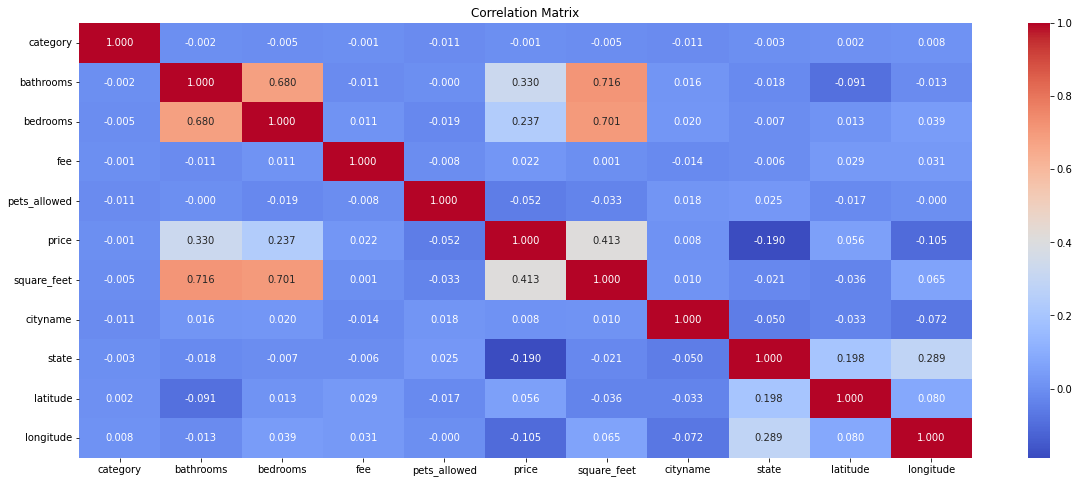

In [31]:
correlation_matrix = df.corr()

plt.figure(figsize=(20, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".3f")
plt.title('Correlation Matrix')
plt.show()

- Giữa category và price có mối tương quan âm rất thấp (-0.001) nên có thể thấy category không ảnh hưởng quá nhiều đến kết quả price. Điều này có thể dễ hiểu vì cột fee bị mất cân bằng dữ liệu rất nhiều.
- Giữa bathrooms và price có mối tương quan dương yếu (0.33) điều này cho thấy một căn hộ có nhiều phòng tắm thì giá của căn hộ đó cũng sẽ cao.
- Giữa bedrooms và price có mối tương quan dương yếu (0.237) điều này cho thấy một căn hộ có nhiều phòng ngủ thì giá của căn hộ đó cũng sẽ cao.
- Giữa fee và price có mối tương quan dương rất thấp (0.022) nên có thể thấy với bộ dữ liệu của chúng ta thì fee sẽ không ảnh hưởng quá nhiều đến kết quả price. Điều này có thể dễ hiểu vì cột fee bị mất cân bằng dữ liệu rất nhiều.
- Giữa pets_allowed và price có mối tương quan âm rất thấp (-0.052) nên có thể thấy pets_allowed không ảnh hưởng quá nhiều đến kết quả price. Điều này cho biết với bộ dữ liệu của chúng ta việc một căn hộ có cho nuôi thú cưng hay không sẽ không ảnh hưởng quá nhiều đến kết quả.
- Giữa square_feet và price có mối tương quan dương khá cao (0.413) điều này cho thấy một căn hộ có diện tích lớn thì giá của căn hộ đó cũng sẽ cao và ngược lại.
- Giữa cityname và price có mối tương quan dương rất thấp (-0.008) điều này cho thấy với bộ dữ liệu này việc một căn hộ ở thành phố nào sẽ không ảnh hưởng quá nhiều đến giá nhà.
- Giữa state và price có mối tương quan âm yếu (-0.19) điều này cho thấy một căn hộ ở state nào cũng sẽ có ảnh hưởng đến giá của nó.
- Còn về latitude và longitude thì 2 cột này đi chung với nhau nên sẽ không sử dụng correlation để lựa chọn đặc trưng. Nhưng ta có thể ngầm hiểu 1 việc rằng state có ảnh hưởng đến price và latitude, longitude chính là tọa độ của căn hộ nên nó cũng sẽ ảnh hưởng đến price.
- Còn về cột amenities do là thuộc loại category nên cũng sẽ không sử dụng phương pháp này, nhưng với kiến thức thông thường của chúng ta có thể hiểu được một căn hộ khi có nhiều tiện ích thì giá nó cũng sẽ cao hơn.

=> Chọn cột bathrooms, bedrooms, square_feet, state, amenities, latitude, longitude

In [32]:
df = df[['bathrooms', 'bedrooms', 'square_feet', 'state', 'amenities', 'latitude', 'longitude', 'price']]
df.head()

,bathrooms,bedrooms,square_feet,state,amenities,latitude,longitude,price
id,,,,,,,,
5668640009,1.0,1.0,542,4,,33.8520,-118.3759,2195.0
5668639818,1.5,3.0,1500,45,,37.0867,-76.4941,1250.0
5668639686,2.0,3.0,1650,32,,35.8230,-78.6438,1395.0
5668639659,1.0,2.0,820,4,,38.3622,-121.9712,1600.0
5668639374,1.0,1.0,624,30,,35.1038,-106.6110,975.0


# 6. Chia tập train, test

In [33]:
# Lấy mẫu ngẫu nhiên cho bộ train
df_train = df.sample(n=int(len(df) * 0.8), random_state=42)

# Bộ test là những mẫu không thuộc bộ train
df_test = df.drop(df_train.index)

# Reset index nếu bạn muốn có index liên tục
df_train.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)

df_train.to_csv('../dataset preprocessed/data_train.csv', index=False)
df_test.to_csv('../dataset preprocessed/data_test.csv', index=False)

In [34]:
df_train.shape

(79205, 8)

In [35]:
df_test.shape

(19783, 8)

# Check outlier

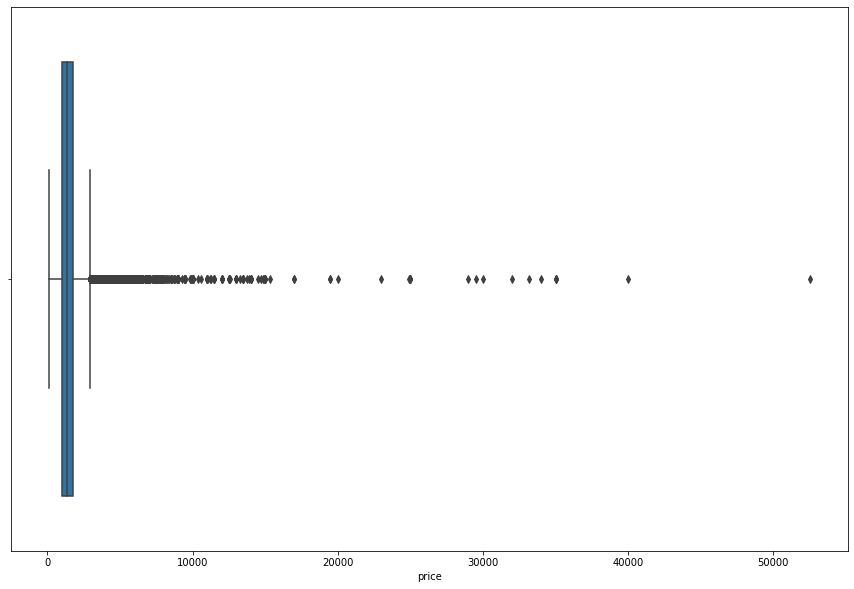

In [36]:
# Vẽ boxplot
plt.figure(figsize=(15,10))
sns.boxplot(x=df['price'])
plt.show()

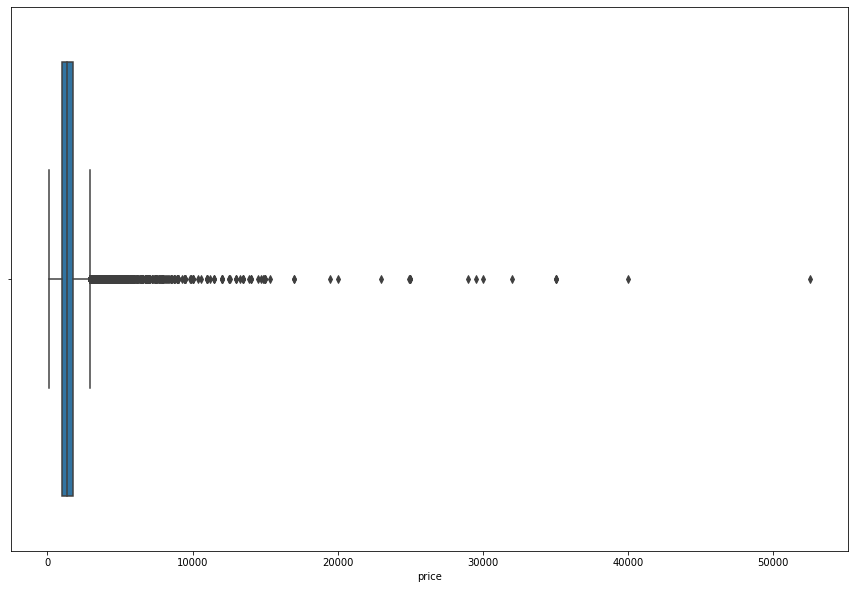

In [37]:
# Vẽ boxplot
plt.figure(figsize=(15,10))
sns.boxplot(x=df_train['price'])
plt.show()

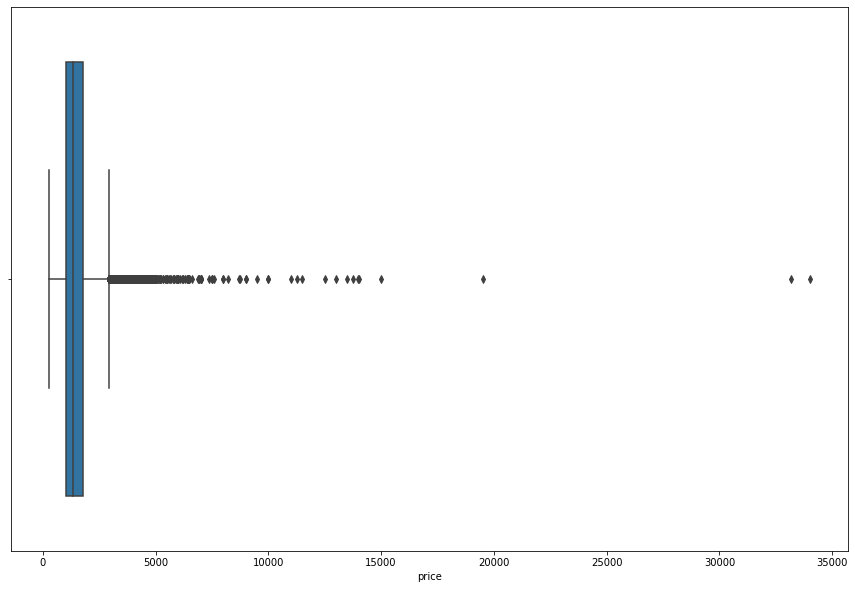

In [38]:
# Vẽ boxplot
plt.figure(figsize=(15,10))
sns.boxplot(x=df_test['price'])
plt.show()